## Часть 2 - анализ текстовых данных

Провести аналитику текстовых данных.

1. Токенезировать и лемматизировать полученные текстовые данные полученные из 1 части задания

- Токенизация - разделение слов на предложения
- Лемматизация - перевод слов в начальную форму

2. Посчитать наиболее встречающиеся пары подлежащих и сказуемых
3. Посчитать самые популлярные слова (исключая стоп-слова, словарь стоп слов можно найти в nltk, либо отбросить по частям речи)
4. Вывести статистику (по убыванию, наиболее встречающеся пары и самые популярные слова за исключением стоп-слов)

In [7]:
# Импорты
!pip install natasha
!pip install nltk
!pip install matplotlib
!pip install seaborn
!pip install setuptools
import sqlite3
import natasha
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
nltk.download('stopwords')

  Using cached setuptools-70.0.0-py3-none-any.whl.metadata (5.9 kB)
Using cached setuptools-70.0.0-py3-none-any.whl (863 kB)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\green\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
conn = sqlite3.connect('articles.db')
CURSOS = conn.cursor()
CURSOS.execute('''SELECT title FROM articles LIMIT 20''')
titles = CURSOS.fetchall()
CURSOS.execute('''SELECT body FROM articles LIMIT 20''')
texts = CURSOS.fetchall()

In [8]:
data = dict(zip(titles, texts)) # p.s. здесь вы открываете полученные данные

# Для примера можно использовать natasha
# !pip install natasha
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

Синтаксис

In [10]:
from ipymarkup import show_dep_ascii_markup as show_markup
articles = list(data.values())
article = articles[19]


doc = Doc(str(article))
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
doc.tag_morph(morph_tagger)

for sentence in doc.sents: # получаем предложения
  sentence.syntax.print()

        ┌──► (               punct
        │ ┌► '               punct
      ┌─└─└─ Фото            
      │   ┌► :               punct
  ┌─┌─└►┌─└─ Ирина           parataxis
  │ │   └──► Бужор           flat:name
  │ └──────► /               punct
  └────►┌─┌─ Коммерсантъ     conj
        │ └► \               punct
        └──► n               appos
          ┌► Бывшего         amod
┌►┌───┌───└─ командующего    obj
│ │ ┌►│      58-й            amod
│ │ │ │ ┌──► гвардейской     amod
│ │ │ │ │ ┌► общевойсковой   amod
│ │ │ └►└─└─ армией          nmod
│ └►└─────┌─ генерала-майора nmod
│       ┌─└► Ивана           appos
│       └──► Попова          flat:name
│         ┌► не              advmod
└─────┌─┌─└─ выпустили       
      │ │ ┌► из              case
      │ └►└─ СИЗО            obl
      └────► .               punct
                ┌► Суд            nsubj
┌─┌───────────┌─└─ оставил        
│ │           │ ┌► апелляционную  amod
│ │           └►└─ жалобу         obj
│ │             ┌

Токенизация и Лемминизация

In [11]:
# Токенизация
for sentence in doc.sents:
  for token in sentence.tokens:
    print(token)

# Лемминизация
for sentence in doc.sents:
  for token in sentence.tokens:
    token.lemmatize(morph_vocab)
  lemmas = {_.text: _.lemma for _ in sentence.tokens}
  print(lemmas.items())

DocToken(stop=1, text='(', id='1_1', head_id='1_3', rel='punct', pos='PUNCT')
DocToken(start=1, stop=2, text="'", id='1_2', head_id='1_3', rel='punct', pos='PUNCT')
DocToken(start=2, stop=6, text='Фото', id='1_3', head_id='1_0', rel='root', pos='NOUN', feats=<Inan,Nom,Neut,Sing>)
DocToken(start=6, stop=7, text=':', id='1_4', head_id='1_5', rel='punct', pos='PUNCT')
DocToken(start=8, stop=13, text='Ирина', id='1_5', head_id='1_3', rel='parataxis', pos='PROPN', feats=<Anim,Nom,Fem,Sing>)
DocToken(start=14, stop=19, text='Бужор', id='1_6', head_id='1_5', rel='flat:name', pos='PROPN', feats=<Anim,Nom,Fem,Sing>)
DocToken(start=20, stop=21, text='/', id='1_7', head_id='1_5', rel='punct', pos='PUNCT')
DocToken(start=22, stop=33, text='Коммерсантъ', id='1_8', head_id='1_5', rel='conj', pos='PROPN', feats=<Inan,Nom,Masc,Sing>)
DocToken(start=33, stop=34, text='\\', id='1_9', head_id='1_8', rel='punct', pos='X', feats=<Yes>)
DocToken(start=34, stop=35, text='n', id='1_10', head_id='1_8', rel='ap

Подлежащее и сказуемое

In [12]:
pairs = {}
for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
        token.lemmatize(morph_vocab)
        if token.rel in {"nsubj", "root"}:
            if token.rel == "nsubj":
                nsubj = token.lemma
            elif token.rel == "root":
                root = token.lemma
            if nsubj and root:
                pairs[nsubj] = root

all_pairs = []
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.rel == "nsubj":
        nsubj = token.lemma
      if token.rel == 'root':
        root = token.lemma
      if nsubj and root:
        all_pairs.append((nsubj, root))

print(all_pairs)
all_pairs_count = Counter(all_pairs)
all_pairs_count.most_common(20)

[('канцлер', 'сделать'), ('канцлер', 'сделать'), ('канцлер', 'сделать'), ('канцлер', 'сделать'), ('канцлер', 'сделать'), ('канцлер', 'передавать'), ('ntv', 'передавать'), ('ntv', 'передавать'), ('ntv', 'передавать'), ('ntv', 'передавать'), ('ntv', 'передавать'), ('мы', 'передавать'), ('мы', 'передавать'), ('мы', 'довести'), ('мы', 'довести'), ('мы', 'довести'), ('мы', 'довести'), ('мы', 'довести'), ('мы', 'довести'), ('ответственность', 'таков'), ('ответственность', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('мы', 'таков'), ('канцлер', 'таков'), ('канцлер', 'прокомментировать'), ('канцлер', 'прокомментировать'), ('ка

[(('зеленский', 'рассказать'), 45),
 (('москва', 'уточнить'), 42),
 (('попов', 'пытаться'), 41),
 (('прокуратура', 'сообщать'), 40),
 (('он', 'подчеркнуть'), 37),
 (('россия', 'пожаловаться'), 34),
 (('пограничник', 'отметить'), 34),
 (('москва', 'заявить'), 34),
 (('прокуратура', 'установить'), 33),
 (('минобороны', 'пресечь'), 33),
 (('издание', 'прийтись'), 32),
 (('суд', 'оставить'), 30),
 (('хроника', 'пострадать'), 30),
 (('он', 'раскритиковать'), 28),
 (('посольство', 'пожаловаться'), 28),
 (('страна', 'уточняться'), 27),
 (('столтенберг', 'заявить'), 27),
 (('один', 'блокировать'), 26),
 (('сумма', 'утверждать'), 26),
 (('сторона', 'заявить'), 26)]

Наиболее частовстречающиеся слова, исключая стоп слова, знаки пунктуации и числа, а также англ. n (знак переноса строки)

In [13]:
import string
filtered = []
punctuation = set(string.punctuation + '«»—' + string.digits + 'n')
stop_words = set(stopwords.words('russian'))
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.lemma not in punctuation and token.lemma not in stop_words:
        filtered.append(token.lemma)

filtered_count = Counter(filtered)
filtered_count.most_common(20)

[('это', 52),
 ('украина', 46),
 ('россия', 45),
 ('фото', 33),
 ('российский', 31),
 ('военный', 24),
 ('страна', 24),
 ('который', 23),
 ('слово', 21),
 ('май', 19),
 ('попов', 17),
 ('reuters', 16),
 ('заявить', 16),
 ('актив', 16),
 ('киев', 15),
 ('свой', 15),
 ('отметить', 15),
 ('год', 15),
 ('мочь', 15),
 ('стать', 14)]

Визуализация

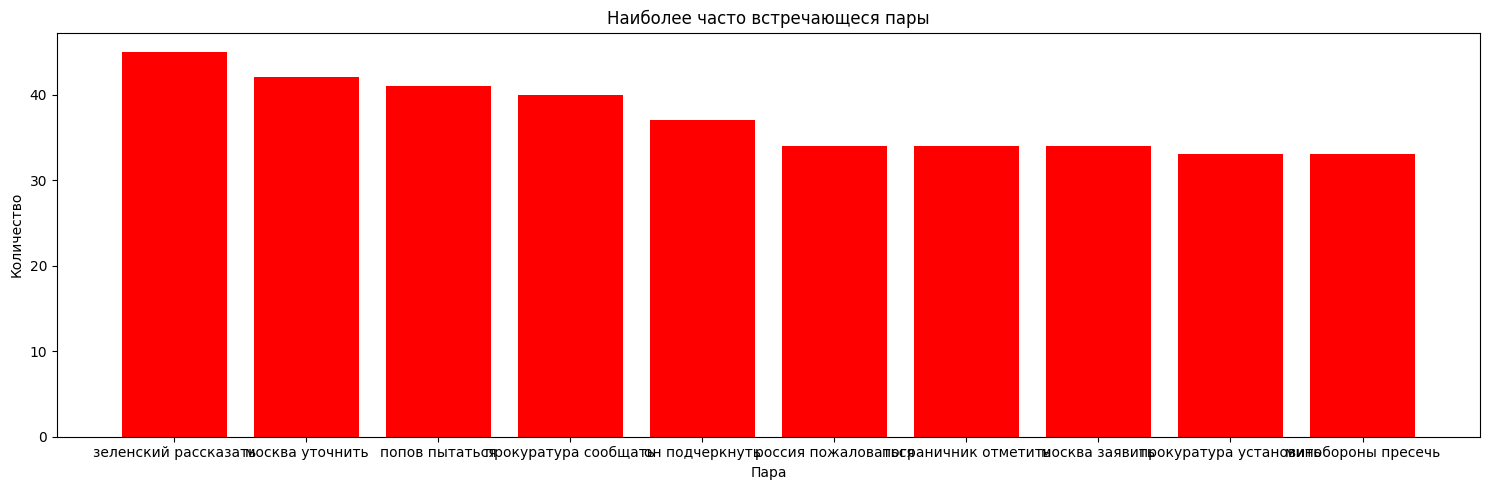

In [25]:
pairs = [pair[0][0] + ' ' + pair[0][1] for pair in all_pairs_count.most_common(10)]
count = [pair[1] for pair in all_pairs_count.most_common(10)]

plt.figure(figsize=(15, 5))
plt.bar(pairs, count, color = 'red')
plt.title("Наиболее часто встречающеся пары")
plt.ylabel("Количество")
plt.xlabel("Пара")
plt.tight_layout()
plt.show()

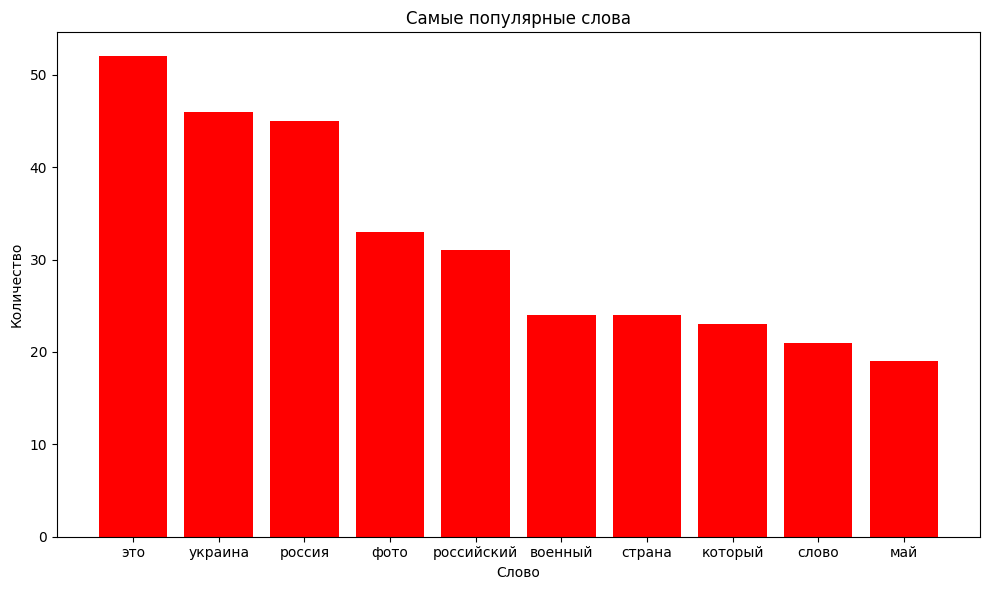

In [26]:
words = [pair[0] for pair in filtered_count.most_common(10)]
count = [pair[1] for pair in filtered_count.most_common(10)]

plt.figure(figsize=(10, 6))
plt.bar(words, count, color = 'red')
plt.title("Самые популярные слова")
plt.ylabel("Количество")
plt.xlabel("Слово")
plt.tight_layout()
plt.show()